<a href="https://colab.research.google.com/github/AakankshaDahiya/Big-Data-Assignment/blob/main/primarydataanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np

# reading files
df= pd.read_csv("/content/primary_for_python_analysis.csv")

In [4]:
# Tidy stray/blank headers that sometimes appear in exports
df.columns = df.columns.str.strip()
df = df.drop(columns=[c for c in df.columns if c.lower().startswith("unnamed:")], errors="ignore")

In [5]:
# 2) STANDARDISE HEADERS (short, analysis-friendly names)
rename_map = {
    'What is your Age group?': 'AgeGroup',
    'Gender': 'Gender',
    'Occupation': 'Occupation',
    'Country of Residence': 'Country',
    'Do you use fitness tracker or app?': 'UsesTracker',
    'Average Daily Steps count': 'Steps',
    'Weekly Exercise Frequency': 'ExerciseFreq',
    'Average Duration of Exercise Sessions': 'ExerciseDuration',
    'Average sleep duration per night': 'SleepHours',
    'Do you monitor your heart rates via wearables?': 'HR_Monitored',
    'Do you track your calorie intake using app?': 'TracksCalories',
    'Average Daily calorie intake (if known)': 'CaloriesIntake',
    'Frequency of fast food consumption': 'FastFoodFreq',
    'Frequency of Sugar drink consumption': 'SugaryDrinkFreq',
    'Daily water intake': 'WaterIntake',
    'Preferred Diet type': 'DietType',
    'Do you Smoke?': 'Smoke',
    'Do you consume Alcohol?': 'Alcohol',
    'How would you rate you stress level?': 'Stress',
    'How would you rate your overall health?': 'HealthRating',
    'Height (in cm)': 'Height_cm',
    'Weight (in kg)': 'Weight_kg',
    'What motivates you to track your fitness or nutrition?': 'Motivation_Text',
    'What challenges do you face in maintaining a healthy lifestyle?': 'Challenges_Text'
}
df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})

In [6]:
# 3) HARMONISE TEXT (replace fancy dashes, align phrasing for mapping later)
def harmonize_choice(s):
    if pd.isna(s): return s
    s = str(s).strip().replace("–","-").replace("—","-")
    s = s.replace("times per week","times/week")
    s = s.replace("1 to 2 times","1-2 times").replace("3 to 4 times","3-4 times")
    return s

for c in ['ExerciseFreq','ExerciseDuration','FastFoodFreq','SugaryDrinkFreq','WaterIntake',
          'AgeGroup','Gender','Occupation','Country','UsesTracker','TracksCalories',
          'HR_Monitored','Smoke','Alcohol','DietType']:
    if c in df.columns:
        df[c] = df[c].apply(harmonize_choice)

In [7]:
 #4) COERCE NUMERICS (ensures math works and plots draw properly)
for c in ['Steps','SleepHours','CaloriesIntake','Stress','HealthRating','Height_cm','Weight_kg']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

In [8]:
# 5) ENCODE ORDERED CATEGORIES → NUMBERS (so we can correlate/regress)
freq_map   = {"None":0, "1-2 times":1.5, "3-4 times":3.5, "5+ times":5}
dur_map    = {"Less than 30 min":0.5, "30-60 min":1.0, "1-2 hours":1.5, "2+ hours":2.5}
ff_map     = {"Never":0, "1-2 times/week":1.5, "3-4 times/week":3.5, "5+ times/week":6}
sd_map     = {"Never":0, "1-2 times/week":1.5, "3-4 times/week":3.5, "Daily":7}
water_map  = {"Less than 1L":0.75, "1-2L":1.5, "2-3L":2.5, "3+L":3.25}

if 'ExerciseFreq' in df:     df['ExerciseFreq_num'] = df['ExerciseFreq'].map(freq_map)
if 'ExerciseDuration' in df: df['ExerciseDuration_num'] = df['ExerciseDuration'].map(dur_map)
if 'FastFoodFreq' in df:     df['FastFoodFreq_num'] = df['FastFoodFreq'].map(ff_map)
if 'SugaryDrinkFreq' in df:  df['SugaryDrinkFreq_num'] = df['SugaryDrinkFreq'].map(sd_map)
if 'WaterIntake' in df:      df['WaterIntake_num'] = df['WaterIntake'].map(water_map)

In [9]:
# 6) FEATURE ENGINEERING: BMI and WHO category
if {'Height_cm','Weight_kg'}.issubset(df.columns):
    h_m = df['Height_cm']/100.0
    df['BMI'] = df['Weight_kg'] / (h_m**2)
    def bmi_cat(x):
        if pd.isna(x): return np.nan
        if x < 18.5: return "Underweight"
        if x < 25:   return "Normal"
        if x < 30:   return "Overweight"
        return "Obese"
    df['BMI_Category'] = df['BMI'].apply(bmi_cat)

In [10]:
# 7) OUTLIER CONTROL (1st–99th percentile clamp on core numerics)
for c in [x for x in ['Steps','SleepHours','CaloriesIntake','Stress','HealthRating','BMI'] if x in df.columns]:
    lo, hi = df[c].quantile([0.01, 0.99])
    df[c] = df[c].clip(lo, hi)

In [11]:
# 8) SAVE ANALYSIS-READY FILES
df.to_csv("primary_clean_latest.csv", index=False)  # full master for Python

tableau_cols = [c for c in [
    'AgeGroup','Gender','Occupation','Country','UsesTracker',
    'Steps','ExerciseFreq','ExerciseDuration','SleepHours',
    'HR_Monitored','TracksCalories','CaloriesIntake',
    'FastFoodFreq','SugaryDrinkFreq','WaterIntake','DietType',
    'Smoke','Alcohol','Stress','HealthRating','Height_cm','Weight_kg',
    'BMI','BMI_Category','ExerciseFreq_num','ExerciseDuration_num',
    'FastFoodFreq_num','SugaryDrinkFreq_num','WaterIntake_num'
] if c in df.columns]
df[tableau_cols].to_csv("primary_for_tableau.csv", index=False)  # lean file for Tableau

print("Saved: primary_clean_latest.csv  &  primary_for_tableau.csv")

Saved: primary_clean_latest.csv  &  primary_for_tableau.csv


In [12]:
# Exploratory Analysis
import matplotlib.pyplot as plt

# 1) Tabular summary for core metrics
core = ['Steps','SleepHours','CaloriesIntake','BMI','Stress','HealthRating']
print(df[core].describe().T)   # mean, std, min, quartiles, max

                count         mean          std        min          25%  \
Steps            96.0  6862.677083  8059.052995   0.000000  2000.000000   
SleepHours        0.0          NaN          NaN        NaN          NaN   
CaloriesIntake   21.0  1679.904762  1030.759036   8.000000  1200.000000   
BMI              95.0  1433.083130  6141.372403  17.873361    22.488413   
Stress          116.0     2.646552     1.105357   1.000000     2.000000   
HealthRating    116.0     3.675000     0.812899   1.150000     3.000000   

                        50%          75%           max  
Steps           5000.000000  8250.000000  51500.000000  
SleepHours              NaN          NaN           NaN  
CaloriesIntake  1800.000000  2500.000000   3000.000000  
BMI               24.543462    26.858084  39490.021815  
Stress             3.000000     3.000000      5.000000  
HealthRating       4.000000     4.000000      5.000000  


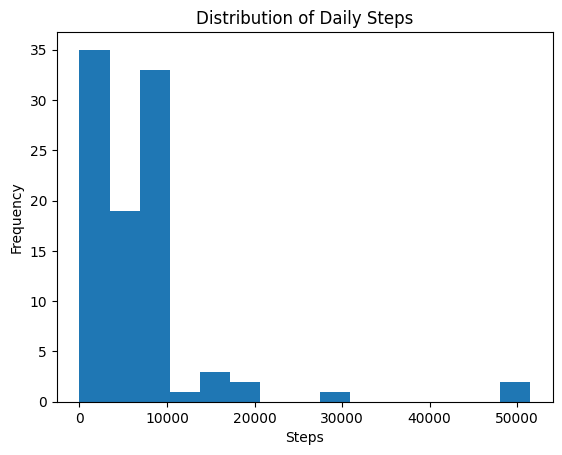

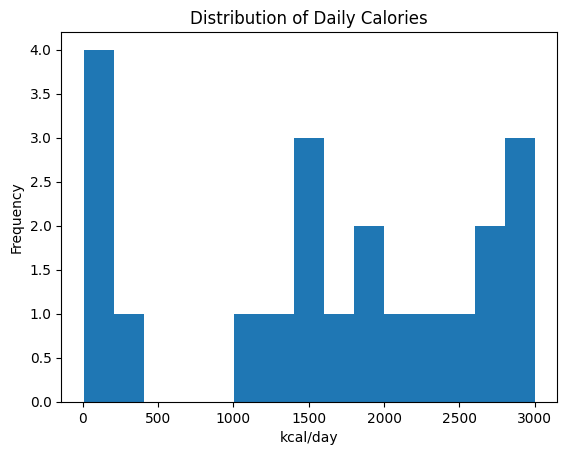

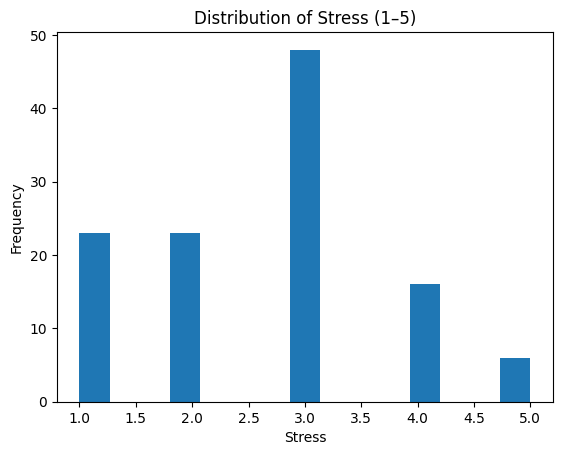

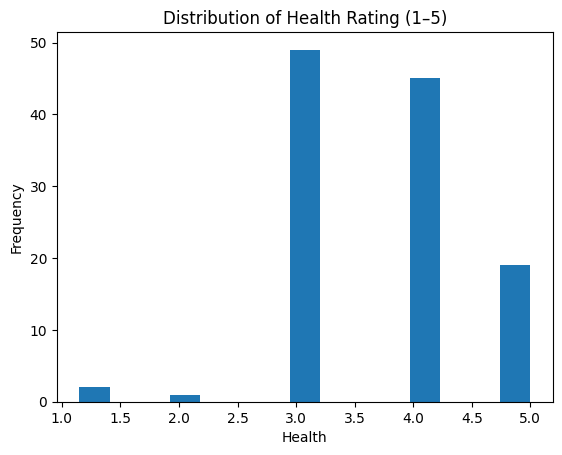

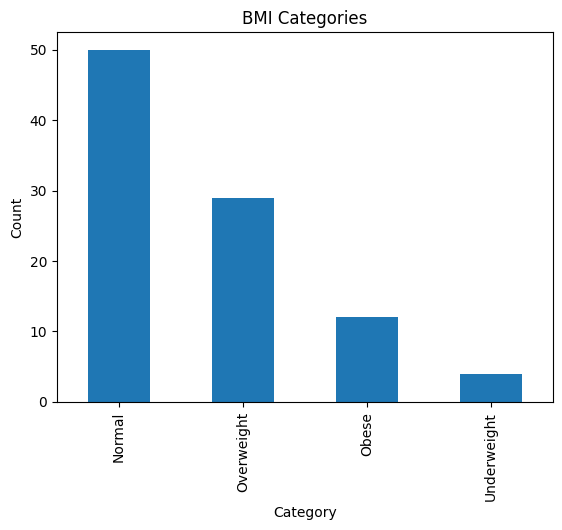

In [13]:
# 2) Histograms (distribution checks)
for col, title, xlabel in [
    ('Steps','Daily Steps','Steps'),
    ('SleepHours','Sleep Hours','Hours/night'),
    ('CaloriesIntake','Daily Calories','kcal/day'),
    ('Stress','Stress (1–5)','Stress'),
    ('HealthRating','Health Rating (1–5)','Health')
]:
    if col in df.columns:
        s = pd.to_numeric(df[col], errors='coerce').dropna()
        if len(s) > 0:
            plt.figure()
            plt.hist(s, bins=15)
            plt.title(f"Distribution of {title}")
            plt.xlabel(xlabel); plt.ylabel("Frequency")
            plt.show()

  # Bar chart: BMI categories
df["BMI_Category"].value_counts().plot(kind="bar")
plt.title("BMI Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

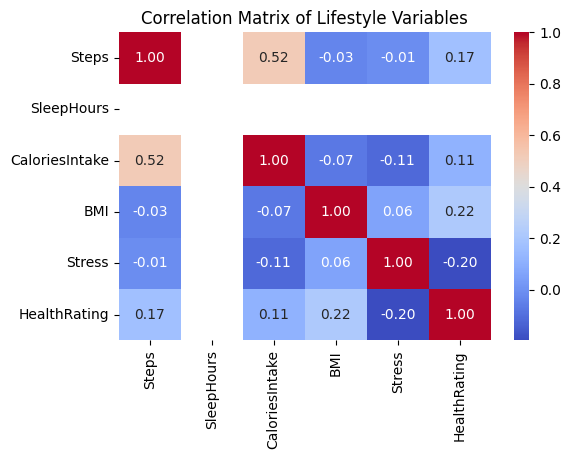

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric variables
num_cols = ["Steps", "SleepHours", "CaloriesIntake", "BMI", "Stress", "HealthRating"]
corr = df[num_cols].corr(method="pearson")

# Plot correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Lifestyle Variables")
plt.show()



=== Relational (Correlation) Analysis ===
Steps vs HealthRating: r=0.168, p=0.1009 (n=96)


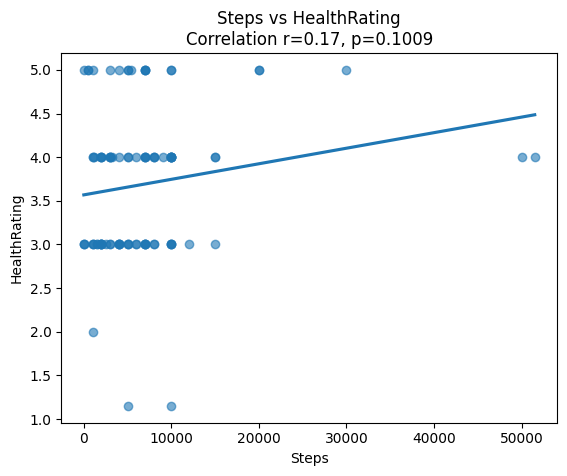

SleepHours vs HealthRating: Not enough valid data.
BMI vs HealthRating: r=0.216, p=0.0358 (n=95)


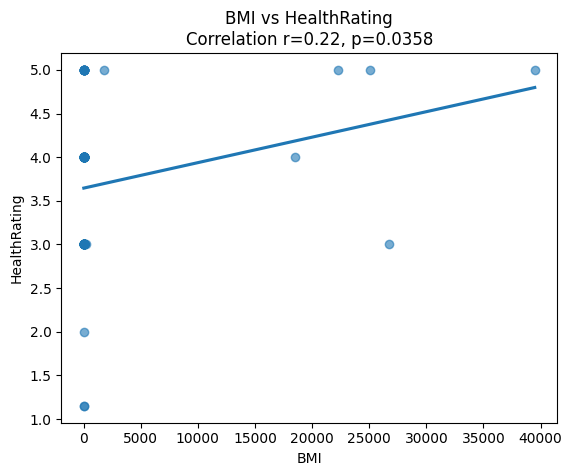

Stress vs HealthRating: r=-0.197, p=0.0343 (n=116)


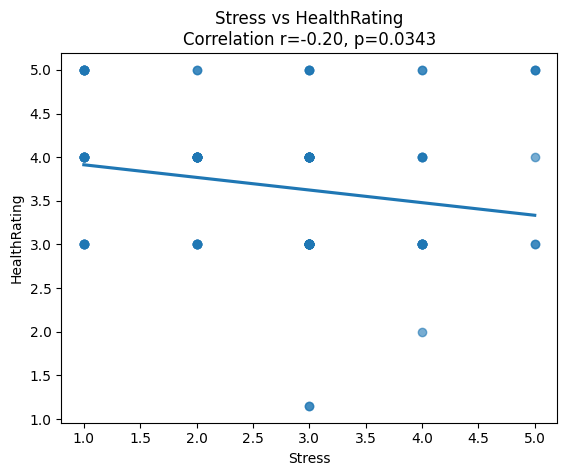

Steps vs BMI: r=-0.035, p=0.7527 (n=85)


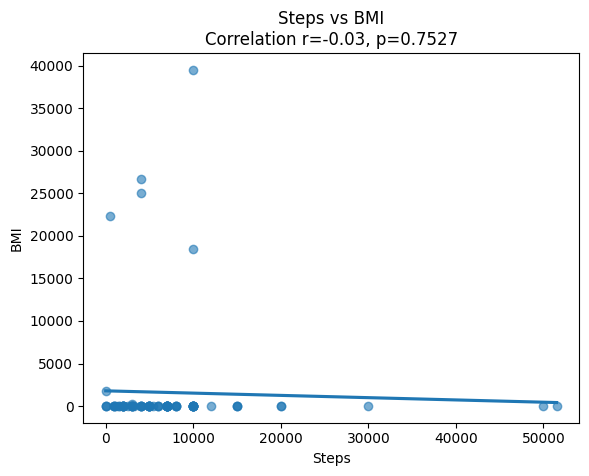

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Key variables for relational analysis
pairs = [
    ("Steps", "HealthRating"),
    ("SleepHours", "HealthRating"),
    ("BMI", "HealthRating"),
    ("Stress", "HealthRating"),
    ("Steps", "BMI")
]

results = []

print("\n=== Relational (Correlation) Analysis ===")
for x, y in pairs:
    if x in df.columns and y in df.columns:
        # Convert to numeric safely
        xvals = pd.to_numeric(df[x], errors="coerce")
        yvals = pd.to_numeric(df[y], errors="coerce")

        # Drop missing
        mask = xvals.notna() & yvals.notna()
        if mask.sum() > 2:
            r, p = pearsonr(xvals[mask], yvals[mask])
            results.append((x, y, round(r,3), round(p,4)))
            print(f"{x} vs {y}: r={r:.3f}, p={p:.4f} (n={mask.sum()})")

            # Scatterplot with regression line
            plt.figure()
            sns.regplot(x=xvals[mask], y=yvals[mask], ci=None, scatter_kws={"alpha":0.6})
            plt.title(f"{x} vs {y}\nCorrelation r={r:.2f}, p={p:.4f}")
            plt.xlabel(x)
            plt.ylabel(y)
            plt.show()
        else:
            print(f"{x} vs {y}: Not enough valid data.")
    else:
        print(f"{x} or {y} not in dataset.")

# Save results as CSV (optional)
pd.DataFrame(results, columns=["Var1","Var2","Pearson_r","p_value"]).to_csv("relational_analysis_results.csv",index=False)

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

# Select variables for clustering
X = df[["Steps", "CaloriesIntake", "BMI", "Stress"]].dropna()

# Standardize variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
X["Cluster"] = kmeans.fit_predict(X_scaled)

# Profile clusters
cluster_profile = X.groupby("Cluster").mean().round(2)
print(cluster_profile)


           Steps  CaloriesIntake       BMI  Stress
Cluster                                           
0        8307.69         2292.31     26.64    2.85
1        4000.00         1600.00  26699.89    3.00
2        1676.25          132.00    463.73    2.75


In [18]:
from google.colab import files
files.download ("primary_for_tableau.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>